**ECON 470 Hwk2-2**

**Author:** Ilse Novis 

**Date:** 2/19/2025  

[GitHub Repository](https://github.com/ilsenovis18/ECON470HW2)

/newpage

In [1]:
%matplotlib inline

# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from IPython.display import Markdown, display
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

In [2]:
# Load and inspect cleaned HCRIS dataset
hcris_data = '/Users/ilsenovis/Documents/GitHub/ECON470HW2/data/output/HCRIS_Data.csv'
data = pd.read_csv(hcris_data)

# Convert the 'fy_start' and 'fy_end' columns to datetime format
data['fy_start'] = pd.to_datetime(data['fy_start'])
data['fy_end'] = pd.to_datetime(data['fy_end'])

# Extract the year from the 'fy_start' column
data['fyear'] = data['fy_start'].dt.year

***Question 1:***  
         How many hospitals filed more than one report in the same year? Show your answer as a line graph of the number of hospitals over time.

In [3]:
# Count distinct providers
number_providers = data['provider_number'].nunique()
print(f"Number of distinct providers: {number_providers}")

# Count duplicate reports per provider per year
duplicate_count = data.groupby(['provider_number', 'fyear']).size().reset_index(name='total_reports')

# Count duplicate reports per year
duplicate_count = duplicate_count[duplicate_count['total_reports'] > 1]

# Summarize duplicates per year
duplicate_summary = duplicate_count.groupby(['fyear'])['total_reports'].sum().reset_index()

Number of distinct providers: 6736


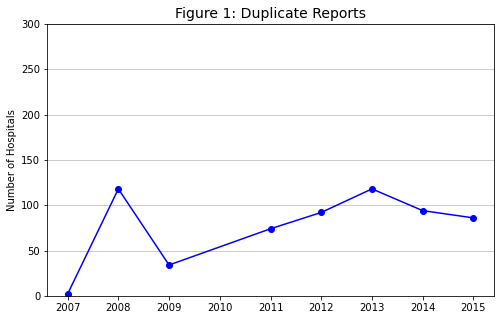

In [4]:
# Plot duplicate reports per year
plt.figure(figsize=(8, 5))
plt.plot(duplicate_summary['fyear'].values, duplicate_summary['total_reports'].values, marker='o', linestyle='-', color='blue')
plt.title('Figure 1: Duplicate Reports', fontsize=14)

# Format plot
plt.xlabel('')
plt.ylabel('Number of Hospitals') 
plt.ylim(0, 300)
plt.grid(axis='y', color='gray', linestyle='-', alpha=0.5)
plt.show()

/newpage

***Question 2:***  
        After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?

In [5]:
duplicate_summary = duplicate_count.groupby(['fyear'])['total_reports'].sum().reset_index()
hospital_count = data.groupby('year').size().reset_index(name='hospital_count')
print(hospital_count)

   year  hospital_count
0  2007              16
1  2008            3525
2  2009            6095
3  2010            2634
4  2011            5815
5  2012            6140
6  2013            6069
7  2014            6067
8  2015            6042
9  2016            2650


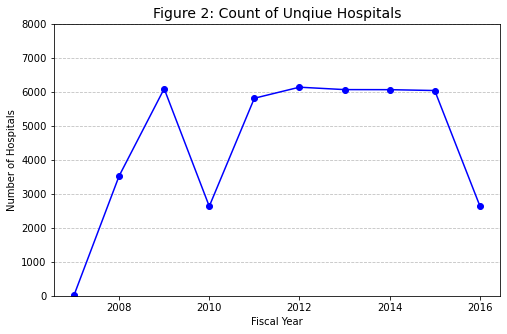

In [6]:
# Count unique hospitals per year
plt.figure(figsize=(8, 5))
plt.plot(hospital_count['year'].values, hospital_count['hospital_count'].values,
         marker='o', linestyle='-', color='blue')
plt.title('Figure 2: Count of Unqiue Hospitals', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Hospitals')
plt.ylim(0, 8000)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

/newpage

***Question 3:***  
       What is the distribution of total charges (tot_charges in the data) in each year? Show your results with a “violin” plot, with charges on the y-axis and years on the x-axis.

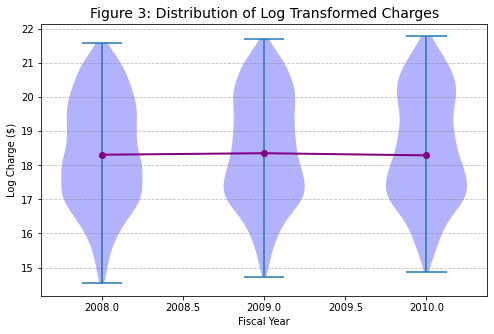

In [7]:
# Filter and preprocess data
charge_data = data.copy()

# Drop rows where 'tot_charges' is NaN 
charge_data = charge_data.dropna(subset=['tot_charges'])

# Compute 1st and 99th percentiles for total charges per year
charge_data['total_charges_lowest'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x, 1))
charge_data['total_charges_highest'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x, 99))

# Filter out extreme values and missing data
charge_data = charge_data[
    (charge_data['tot_charges'] > charge_data['total_charges_lowest']) &
    (charge_data['tot_charges'] < charge_data['total_charges_highest']) &
    charge_data['tot_charges'].notna() &
    (charge_data['year'].between(2008, 2016))
]

# Compute log of total charges
charge_data['log_charge'] = np.log(charge_data['tot_charges'])

# Prepare data for violin plot
years = sorted(charge_data['year'].unique())
violin_data = [charge_data[charge_data['year'] == y]['log_charge'].dropna().values for y in years]

fig, ax = plt.subplots(figsize=(8, 5))
parts = ax.violinplot(violin_data, positions=years, showmedians=False)

for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha(0.3)

# Add median line
median = charge_data.groupby('year')['log_charge'].median()
plt.plot(years, median.values, marker='o', linestyle='-', color='purple', linewidth=2)

# Create plot
plt.title('Figure 3: Distribution of Log Transformed Charges', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Log Charge ($)')
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

/newpage

***Question 4:***  
        What is the distribution of estimated prices in each year? 

In [17]:
print("Total hospitals in 2012 before any filtering:", len(data[data['fyear'] == 2012]))

print("\nChecking for NaN values in key variables:")
print(data[data['fyear'] == 2012][['tot_discharges', 'mcare_discharges', 'price_denom']].isna().sum())

print("\nSummary Statistics Before Filtering:")
print(data[data['fyear'] == 2012][['tot_discharges', 'mcare_discharges', 'price_denom']].describe())

print("\nSample Rows (Before Filtering) from 2012:")
print(data[data['fyear'] == 2012][['tot_discharges', 'mcare_discharges', 'price_denom']].head(10))

Total hospitals in 2012 before any filtering: 6007

Checking for NaN values in key variables:
tot_discharges      0
mcare_discharges    0
price_denom         0
dtype: int64

Summary Statistics Before Filtering:
       tot_discharges  mcare_discharges  price_denom
count          6007.0            6007.0       6007.0
mean           1884.0               0.0       1884.0
std               0.0               0.0          0.0
min            1884.0               0.0       1884.0
25%            1884.0               0.0       1884.0
50%            1884.0               0.0       1884.0
75%            1884.0               0.0       1884.0
max            1884.0               0.0       1884.0

Sample Rows (Before Filtering) from 2012:
    tot_discharges  mcare_discharges  price_denom
4           1884.0               0.0       1884.0
11          1884.0               0.0       1884.0
18          1884.0               0.0       1884.0
26          1884.0               0.0       1884.0
32          1884.0 

In [8]:
# Fix Missing Discharge Data BEFORE Price Calculation
print("Before fixing missing discharges:")
print(data[['tot_discharges', 'mcare_discharges']].isna().sum())

# Fill missing total discharges with the median value
data['tot_discharges'] = data['tot_discharges'].fillna(data['tot_discharges'].median())

# Assume missing Medicare discharges are 0 (common assumption)
data['mcare_discharges'] = data['mcare_discharges'].fillna(0)

# Recalculate price denominator
data['price_denom'] = data['tot_discharges'] - data['mcare_discharges']

# 🚨 Drop hospitals with invalid denominator values
data = data[data['price_denom'] > 0]

print("After fixing missing discharges:")
print(data[['tot_discharges', 'mcare_discharges', 'price_denom']].isna().sum())
print("Valid hospitals left:", len(data))

Before fixing missing discharges:
tot_discharges      32543
mcare_discharges    32613
dtype: int64
After fixing missing discharges:
tot_discharges      0
mcare_discharges    0
price_denom         0
dtype: int64
Valid hospitals left: 44623


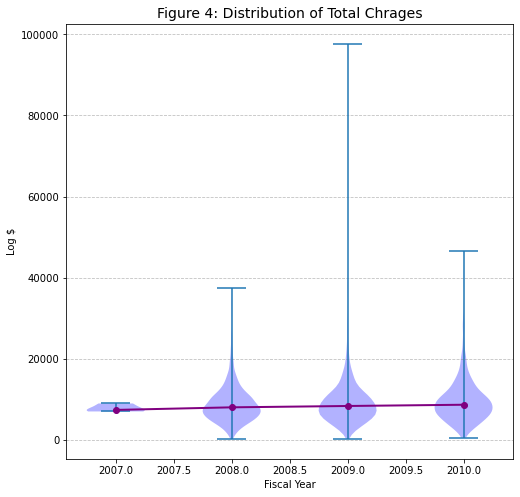

In [9]:
# Compute Price Data
data['discount_factor'] = 1 - data['tot_discounts'] / data['tot_charges']
data['price_num'] = (
    (data['ip_charges'] + data['icu_charges'] + data['ancillary_charges']) *
    data['discount_factor']
) - data['tot_mcare_payment']
data['price_denom'] = data['tot_discharges'] - data['mcare_discharges']
data['price'] = data['price_num'] / data['price_denom']

# Filter the data
price_data = data[
    (data['price_denom'] > 100) &
    (~data['price_denom'].isna()) &
    (data['price_num'] > 0) &
    (~data['price_num'].isna()) &
    (data['price'] < 100000) &
    (data['beds'] > 30) &
    (~data['beds'].isna())
]

# Prepare the data for a violin plot
years = sorted(price_data['year'].unique())
violin_data2 = [price_data[price_data['year'] == y]['price'].dropna().values for y in years]

# Plot distrubtion of total charges
fig, ax = plt.subplots(figsize=(8, 8))
parts = ax.violinplot(violin_data2, positions=years, showmedians=False)

# Customize violin plot
for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha(0.3)

# Add median line
median = price_data.groupby('year')['price'].median()
plt.plot(years, median.values, marker='o', linestyle='-', color='purple', linewidth=2)

# Format Plot
plt.title('Figure 4: Distribution of Total Chrages', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Log $')
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

/newpage

***Question 5:***  
        Calculate the average price among penalized versus non-penalized hospitals. 

In [10]:
# Ensure 'penalty' is created as a float column using. loc
price_data.loc[:, 'penalty'] = (price_data['hvbp_payment'].fillna(0) - price_data['hrrp_payment'].fillna(0)).abs().astype(float)

/var/folders/6z/mn9hb6p56ms_p7_tp4k05vl40000gn/T/ipykernel_52615/2104256875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.loc[:, 'penalty'] = (price_data['hvbp_payment'].fillna(0) - price_data['hrrp_payment'].fillna(0)).abs().astype(float)


In [11]:
# Compute penalty data
price_data.loc[:, 'penalty'] = (price_data['hvbp_payment'].fillna(0) - price_data['hrrp_payment'].fillna(0)) < 0

hcris_2012 = price_data[price_data['year'] == 2012].copy()

#print(price_data['year'].unique())  
print(price_data[price_data['year'] == 2012].shape)

# Filter data for the year 2012
pen_data_2012 = price_data[price_data['year'] == 2012].copy()

print(pen_data_2012[['price', 'penalty']].describe())
print(pen_data_2012['penalty'].value_counts())

# Compute average price by penalty status
avg_pen = pen_data_2012.groupby('penalty')['price'].mean()
print("\nAverage Price by Penalty Status in 2012:")
print(avg_pen)

(0, 32)
       price
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Series([], Name: penalty, dtype: int64)

Average Price by Penalty Status in 2012:
Series([], Name: price, dtype: float64)


/var/folders/6z/mn9hb6p56ms_p7_tp4k05vl40000gn/T/ipykernel_52615/4292841981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.loc[:, 'penalty'] = (price_data['hvbp_payment'].fillna(0) - price_data['hrrp_payment'].fillna(0)) < 0


In [12]:
print(hcris_2012[['price_denom']].describe())  # Check summary stats
print(hcris_2012[['price_denom']].head(10))   # See some sample values

       price_denom
count          0.0
mean           NaN
std            NaN
min            NaN
25%            NaN
50%            NaN
75%            NaN
max            NaN
Empty DataFrame
Columns: [price_denom]
Index: []


/newpage

In [14]:
# Compute quartiles
beds_q1 = pen_data_2012['beds'].quantile(0.25)
beds_q2 = pen_data_2012['beds'].quantile(0.50)
beds_q3 = pen_data_2012['beds'].quantile(0.75)
beds_q4 = pen_data_2012['beds'].max()

# Assign bed quartiles
pen_data_2012['bed_quart'] = np.select(
    [
        pen_data_2012['beds'] < beds_q1,
        (pen_data_2012['beds'] >= beds_q1) & (pen_data_2012['beds'] < beds_q2),
        (pen_data_2012['beds'] >= beds_q2) & (pen_data_2012['beds'] < beds_q3),
        pen_data_2012['beds'] >= beds_q3
    ],
    [1, 2, 3, 4],
    default=0
)

# Filter out invalide quartile values
pen_data_2012 = pen_data_2012[pen_data_2012['bed_quart'] > 0]

In [15]:
# Create indicator variables for quartiles
pen_data_2012['bed_quart_1'] = (pen_data_2012['bed_quart'] == 1).astype(int)
pen_data_2012['bed_quart_2'] = (pen_data_2012['bed_quart'] == 2).astype(int)
pen_data_2012['bed_quart_3'] = (pen_data_2012['bed_quart'] == 3).astype(int)
pen_data_2012['bed_quart_4'] = (pen_data_2012['bed_quart'] == 4).astype(int)

# Check results
print(pen_data_2012[['beds', 'bed_quart', 'bed_quart_1', 'bed_quart_2', 'bed_quart_3', 'bed_quart_4']].head(10))

Empty DataFrame
Columns: [beds, bed_quart, bed_quart_1, bed_quart_2, bed_quart_3, bed_quart_4]
Index: []


***Question 6:***  
        Split hospitals into quartiles based on bed size. Provide a table of the average price among treated/control groups for each quartile. 

In [16]:
# Compute average price by penalty status for each bed quartile
avg_price_by_quart = pen_data_2012.groupby(['bed_quart', 'penalty'])['price'].mean().unstack()

# Display results
import ace_tools as tools  # Assuming you're using ace_tools for table visualization
tools.display_dataframe_to_user(name="Average Price by Bed Quartile & Treatment Group", dataframe=avg_price_by_quart)

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
print(price_data['year'].unique())  # Check available years
print(price_data[price_data['year'] == 2012].shape)  # Check number of rows for 2012